Here we will simulate a CT measurement of someone's head and do tomographic reconstruction to reconstruct the head from what a CT scanner would measure. A CT scanner typically rotates an X-ray beam around a target and collects the resulting magnitude on a number of detector pixels.
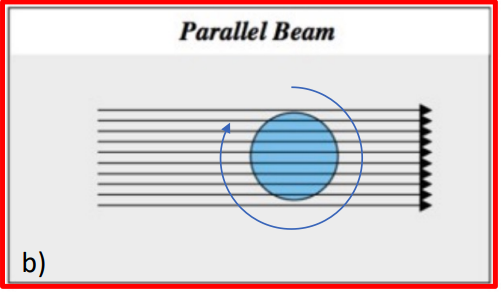
We can illustrate the measurement result by plotting each pixel's detected brightness for each projection angle, called a sinogram. From this sinogram we can then rotate each projection back by the projection angle and smear all of these images together. This should ideally give us back the 2D image we are looking for.
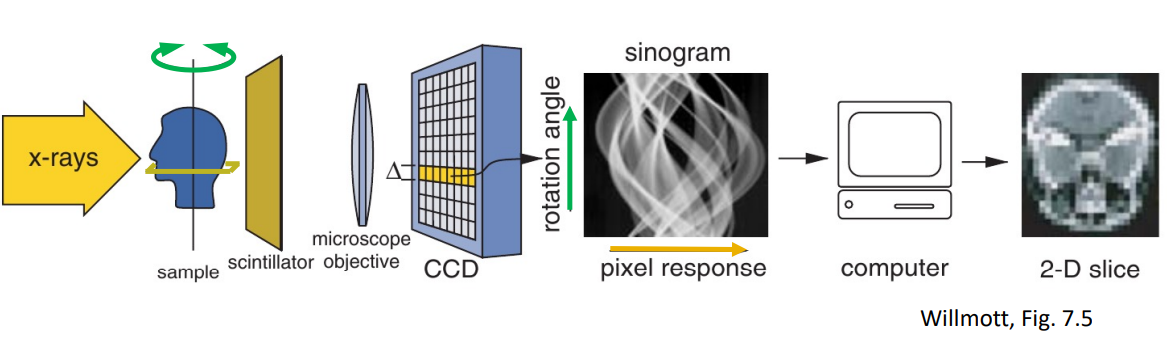


In [1]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

def forwardproject(sample, angles):
    """
    Simulate data aquisition in tomography from line projections.
    Forwardproject a given input sample slice to obtain a simulated sinogram.
    """
    sh = np.shape(sample)                # shape of sample
    Nproj = len(angles)                  # number of projections

    # define empty sinogram container, angles along y-axis
    sinogram = np.zeros((Nproj, sh[1]))

    # loop over all projections
    for proj in np.arange(Nproj):
        print("Simulating:     %03i/%03i" % (proj+1, Nproj), end="\r", flush=True)
        
        im_rot = nd.rotate(sample,angles[proj],reshape=False)
        sinogram[proj,:] = np.sum(im_rot,axis=0)
        
    return sinogram


def backproject(sinogram, angles):
    """
    Backproject a given sinogram.
    We do this by rotating back all the sinogram slices and adding them all together
    """
    
    # define empty container for reconstruction of sample
    Nproj, Npix = np.shape(sinogram)
    reconstruction = np.zeros((Npix, Npix))

    # loop over all projections
    for proj in np.arange(Nproj): 
        print("Reconstructing: %03i/%i" % (proj+1, Nproj), end="\r", flush=True)

        backprojection = np.tile(sinogram[proj, :], (Npix, 1))
        backprojection /= Npix  # Just normalization
        rotated_backprojection = nd.rotate(backprojection,-angles[proj],reshape=False)

        # Add the rotated backprojection
        reconstruction += rotated_backprojection

    return reconstruction

<IPython.core.display.Javascript object>


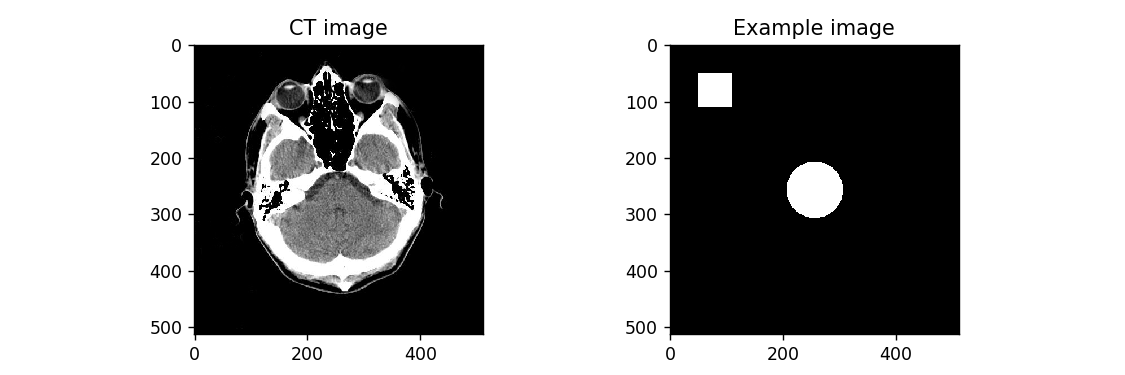

In [2]:
#Reading the gray scale image of a Head
sample = plt.imread('Head_CT_scan.jpg')

sh = sample.shape

#Example image of square and circle as comparison
x,y = np.meshgrid(np.arange(sh[1]),np.arange(sh[0]))
example = np.sqrt((x-sh[1]//2)**2+(y-sh[0]//2)**2) < 50
example[50:110,50:110] = 1
example = example*200


plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('CT image')
plt.imshow(sample, cmap='gray', interpolation='none');

plt.subplot(122)
plt.title('Example image')
plt.imshow(example, cmap='gray', interpolation='none');


<IPython.core.display.Javascript object>


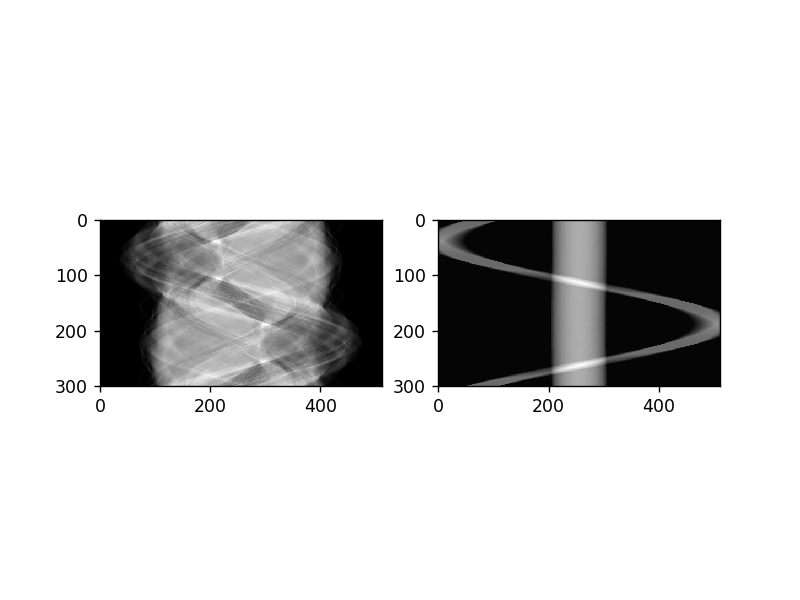

In [3]:
#Preparing projection angles along full 360°, excluding 360°, since 360° = 0°
Nangles = 301
angles = np.linspace(0,360-360/Nangles,Nangles)

#Simulating tomography
sino = forwardproject(sample, angles)
sinoexample = forwardproject(example, angles)

#Plot simulated sinograms
plt.figure()
plt.subplot(121)
plt.imshow(sino)
plt.subplot(122)
plt.imshow(sinoexample)

<IPython.core.display.Javascript object>


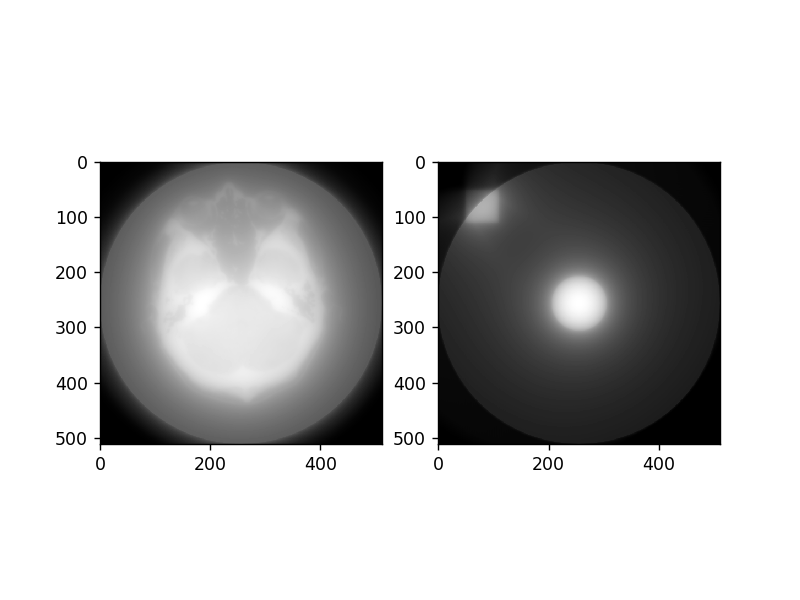

In [4]:
#Unfiltered backprojection
reco = backproject(sino,angles)
recoexample = backproject(sinoexample,angles)

#plot result
plt.figure()
plt.subplot(121)
plt.imshow(reco)
plt.subplot(122)
plt.imshow(recoexample)

Our backprojection is unoptimal in fourier space:
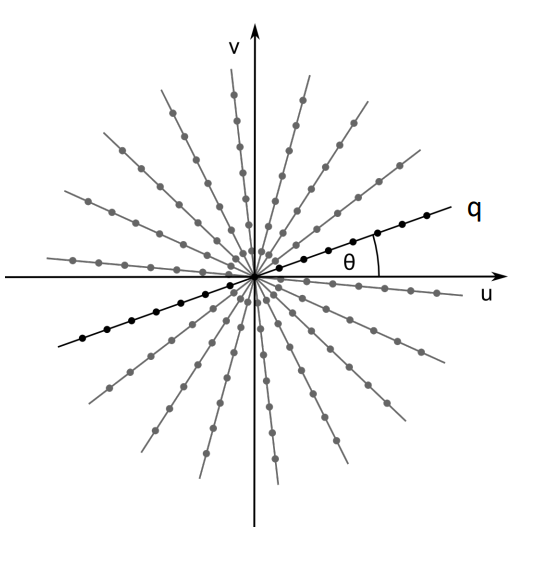
We are sampling lower frequencies very well, but due to the polar nature are undersampling higher frequencies -> edges are blurred.
Express fourier transform in polar coordinates -> equivalent to filtering with ramp filter:
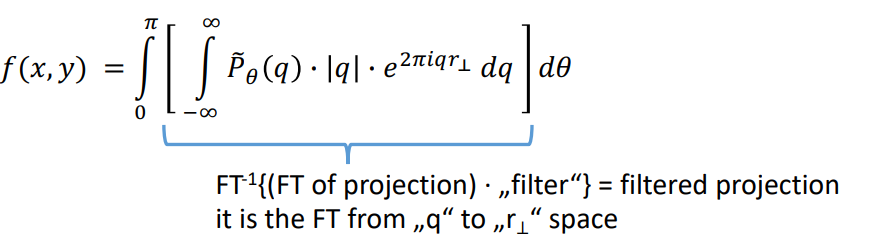

In [5]:
def filter_ramlak(sinogram):
    """
    Filter a given sinogram using a ramp filter
    """

    Nproj, Npix = np.shape(sinogram)

    # Generate basic ramp filter
    ramp_filter = np.abs(np.fft.fftfreq(Npix))

    # filter the sinogram in Fourier space in detector pixel direction
    sino_ft = np.fft.fft(sinogram,axis=1)*ramp_filter

    # Multiply the ramp filter onto the 1D-FT of the sinogram and transform it
    # back into spatial domain
    sino_filtered = np.real(np.fft.ifft(sino_ft))

    return sino_filtered

In [6]:
#Filtered backprojection
reco = backproject(filter_ramlak(sino),angles)
recoexample = backproject(filter_ramlak(sinoexample),angles)


<IPython.core.display.Javascript object>


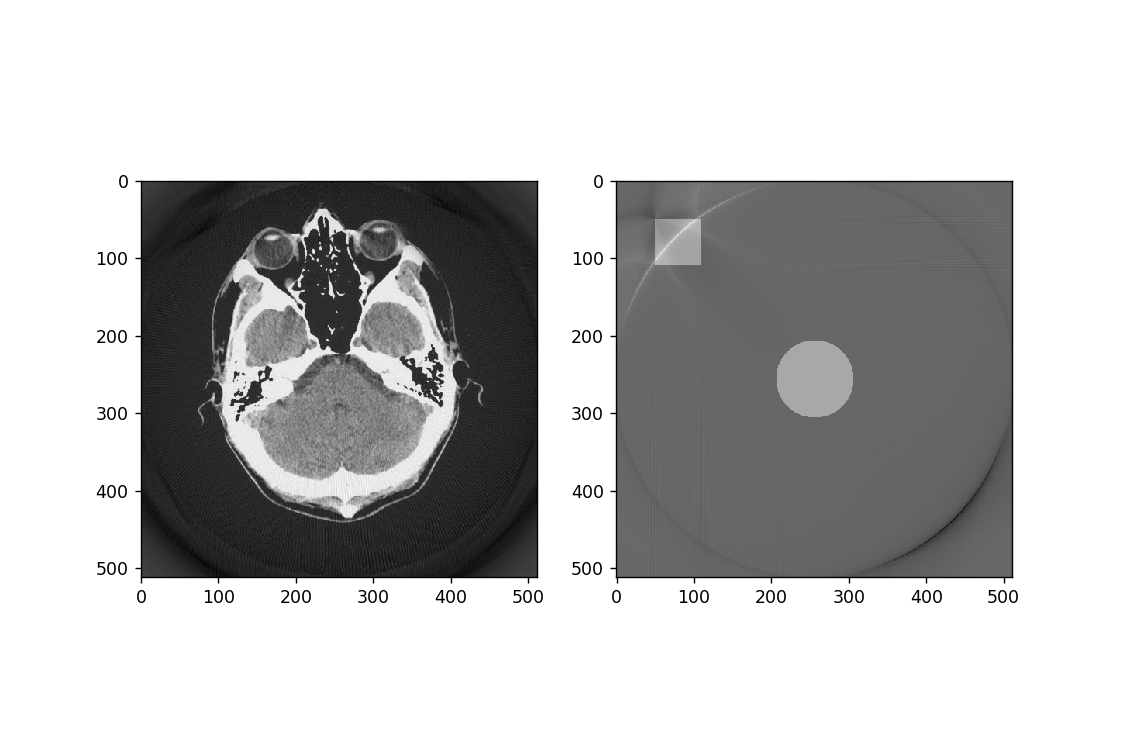

In [8]:
#Save head reconstruction in CSV
df = pd.DataFrame(reco)
df.to_csv('Reconstructedhead.csv')

#plot result
plt.figure(figsize=(9, 6))
plt.subplot(121)
plt.imshow(reco)
plt.subplot(122)
plt.imshow(recoexample)
plt.savefig('FBP')